In [1]:
import math as m
import numpy as np
import random as r
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torch import optim

In [3]:
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.flows.base import Flow
from nflows.transforms.dropout import UniformStochasticDropout
from nflows.transforms.dropout import VariationalStochasticDropout
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform

In [4]:
device = torch.device("cuda:0")
#device = torch.device("cpu")

In [5]:
# This works with any size x
def p(x, n_probs):
    sums = torch.sum(x, axis=1)
    probs = torch.cos(torch.ger(sums, torch.arange(1, n_probs+1, dtype=torch.float32)))**2
    norm = torch.sum(probs, axis=1)

    for i in range(n_probs):
        probs[:,i] /= norm
    
    return probs

In [6]:
def generate(n, drop_indices):
    n_probs = torch.max(drop_indices) + 1
    x = torch.rand(n, drop_indices.shape[0])
    probs = p(x, n_probs)

    # Pick a prob
    probs_cumsum = torch.cumsum(probs, axis=1)

    # Tensor with bools that are true when r passes the cumprob
    larger_than_cumprob = torch.rand(n,1) < probs_cumsum
    # Do the arange trick to find first nonzero
    # This is the HIGHEST LABEL FROM DROP_INDICES THAT IS KEPT
    selected_index = torch.argmax(larger_than_cumprob*torch.arange(n_probs, 0, -1), axis=1)

    '''
    print("The index of the selected probability")
    print("This is also the highest label in drop_indices that is kept")
    print(selected_index)
    ''' 
    
    # Find the index of the first true
    drop_mask = drop_indices > selected_index[:,None]
    x[drop_mask] = 0
    
    return x

In [7]:
drop_indices = torch.tensor([0,0,1,1,1,2,3,3,4])
n_data = int(1e6)
x_data = generate(n_data, drop_indices).to(device)

In [8]:
num_layers = 6
base_dist_uniform = BoxUniform(torch.zeros(drop_indices.shape[0]), torch.ones(drop_indices.shape[0]))
base_dist_variational = BoxUniform(torch.zeros(drop_indices.shape[0]), torch.ones(drop_indices.shape[0]))

transforms_uniform = []
transforms_variational = []

transforms_uniform.append(UniformStochasticDropout(drop_indices))
transforms_variational.append(VariationalStochasticDropout(drop_indices))

for _ in range(num_layers):
    transforms_uniform.append(RandomPermutation(features=drop_indices.shape[0]))
    transforms_uniform.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=drop_indices.shape[0], 
        hidden_features=50,
        num_bins=10,
        num_blocks=4,
    ))

    transforms_variational.append(RandomPermutation(features=drop_indices.shape[0]))
    transforms_variational.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=drop_indices.shape[0], 
        hidden_features=50,
        num_bins=10,
        num_blocks=4,
    ))

transform_uniform = CompositeTransform(transforms_uniform)
transform_variational = CompositeTransform(transforms_variational)

flow_uniform = Flow(transform_uniform, base_dist_uniform).to(device)
flow_variational = Flow(transform_variational, base_dist_variational).to(device)

optimizer_uniform = optim.Adam(flow_uniform.parameters())
optimizer_variational = optim.Adam(flow_variational.parameters())

In [9]:
n_epochs = 100
batch_size = 5000
n_batches = m.ceil(x_data.shape[0]/batch_size)

for epoch in range(n_epochs):
    permutation = torch.randperm(x_data.shape[0], device=device)    

    # Loop over batches
    cum_loss_uniform = 0
    cum_loss_variational = 0
    for batch in range(n_batches):
        # Set up the batch
        batch_begin = batch*batch_size
        batch_end   = min( (batch+1)*batch_size, x_data.shape[0]-1 )
        indices = permutation[batch_begin:batch_end]
        batch_x = x_data[indices]
        
        # Take a step
        optimizer_uniform.zero_grad()
        optimizer_variational.zero_grad()

        loss_uniform = -flow_uniform.log_prob(inputs=batch_x).mean()
        loss_variational = -flow_variational.log_prob(inputs=batch_x).mean()

        loss_uniform.backward()
        loss_variational.backward()

        optimizer_uniform.step()
        optimizer_variational.step()

        # Compute cumulative loss
        cum_loss_uniform = (cum_loss_uniform*batch + loss_uniform.item())/(batch+1)
        cum_loss_variational = (cum_loss_variational*batch + loss_variational.item())/(batch+1)

        print("epoch = ", epoch, "batch = ",batch+1, "/", n_batches, "loss_uniform = ", cum_loss_uniform, " loss_variational = ", cum_loss_variational)

epoch =  0 batch =  1 / 200 loss_uniform =  4.166877746582031  loss_variational =  6.411993503570557
epoch =  0 batch =  2 / 200 loss_uniform =  3.9496012926101685  loss_variational =  6.041798114776611
epoch =  0 batch =  3 / 200 loss_uniform =  3.8008994261423745  loss_variational =  5.709665616353353
epoch =  0 batch =  4 / 200 loss_uniform =  3.6772305965423584  loss_variational =  5.448649525642395
epoch =  0 batch =  5 / 200 loss_uniform =  3.562221574783325  loss_variational =  5.228176879882812
epoch =  0 batch =  6 / 200 loss_uniform =  3.456188917160034  loss_variational =  5.03629732131958
epoch =  0 batch =  7 / 200 loss_uniform =  3.372098582131522  loss_variational =  4.885491779872349
epoch =  0 batch =  8 / 200 loss_uniform =  3.299363523721695  loss_variational =  4.747928768396378
epoch =  0 batch =  9 / 200 loss_uniform =  3.232446829477946  loss_variational =  4.6353978580898705
epoch =  0 batch =  10 / 200 loss_uniform =  3.173026132583618  loss_variational =  4.53

epoch =  0 batch =  81 / 200 loss_uniform =  2.0699156655205626  loss_variational =  2.4999493566560163
epoch =  0 batch =  82 / 200 loss_uniform =  2.0655606679800087  loss_variational =  2.4912930596165546
epoch =  0 batch =  83 / 200 loss_uniform =  2.061139913926642  loss_variational =  2.4827391900211935
epoch =  0 batch =  84 / 200 loss_uniform =  2.0567798032647095  loss_variational =  2.474504758914312
epoch =  0 batch =  85 / 200 loss_uniform =  2.052586113705355  loss_variational =  2.466499045315911
epoch =  0 batch =  86 / 200 loss_uniform =  2.048406768676847  loss_variational =  2.4586029025011285
epoch =  0 batch =  87 / 200 loss_uniform =  2.044346206489651  loss_variational =  2.4507215201169594
epoch =  0 batch =  88 / 200 loss_uniform =  2.0404724654826256  loss_variational =  2.442928052761338
epoch =  0 batch =  89 / 200 loss_uniform =  2.0366057036967766  loss_variational =  2.4352635346101916
epoch =  0 batch =  90 / 200 loss_uniform =  2.032870475451152  loss_va

epoch =  0 batch =  161 / 200 loss_uniform =  1.8713546199087772  loss_variational =  2.116466291202523
epoch =  0 batch =  162 / 200 loss_uniform =  1.8700165579348436  loss_variational =  2.1138594584700514
epoch =  0 batch =  163 / 200 loss_uniform =  1.8686761139360673  loss_variational =  2.1112803330450713
epoch =  0 batch =  164 / 200 loss_uniform =  1.867323629739808  loss_variational =  2.1086979166763595
epoch =  0 batch =  165 / 200 loss_uniform =  1.8660795898148508  loss_variational =  2.1061269911852762
epoch =  0 batch =  166 / 200 loss_uniform =  1.8647763463388007  loss_variational =  2.1035711923277534
epoch =  0 batch =  167 / 200 loss_uniform =  1.8635079739336482  loss_variational =  2.1011426277503293
epoch =  0 batch =  168 / 200 loss_uniform =  1.8622231767291115  loss_variational =  2.0986766162372783
epoch =  0 batch =  169 / 200 loss_uniform =  1.8609519054198407  loss_variational =  2.0962427988560255
epoch =  0 batch =  170 / 200 loss_uniform =  1.859672245

In [10]:
n_sample = 100000
with torch.no_grad():
    x_uniform = flow_uniform.sample(n_sample).cpu().numpy()
    x_variational = flow_variational.sample(n_sample).cpu().numpy()
x_data_plot = x_data.cpu()[:n_sample,:].numpy()

tensor([0.1494, 0.3437, 0.5513, 0.7769, 1.0000], device='cuda:0')
tensor([[False, False, False, False,  True],
        [False,  True,  True,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False,  True],
        [ True,  True,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False,  True,  True],
        [False, False, False,  True,  True],
        [False,  True,  True,  True,  True]], device='cuda:0')


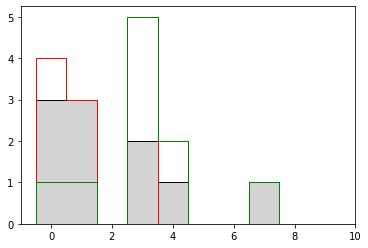

In [11]:
bins = np.linspace(-0.5, drop_indices.shape[0]+0.5, drop_indices.shape[0]+2)
plt.hist(np.sum(x_data_plot == 0, axis=1), histtype='stepfilled', edgecolor="black", facecolor="lightgray", bins = bins)
plt.hist(np.sum(x_uniform == 0, axis=1), edgecolor="red", histtype="step", bins = bins)
plt.hist(np.sum(x_variational == 0, axis=1), edgecolor="green", histtype="step", bins = bins)
plt.show()

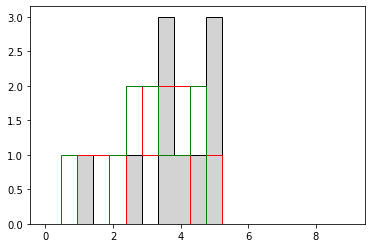

In [12]:
bins = np.linspace(0, drop_indices.shape[0], 20)
plt.hist(np.sum(x_data_plot, axis=1), histtype='stepfilled', edgecolor="black", facecolor="lightgray", bins = bins)
plt.hist(np.sum(x_uniform, axis=1), edgecolor="red", histtype="step", bins = bins)
plt.hist(np.sum(x_variational, axis=1), edgecolor="green", histtype="step", bins = bins)
plt.show()

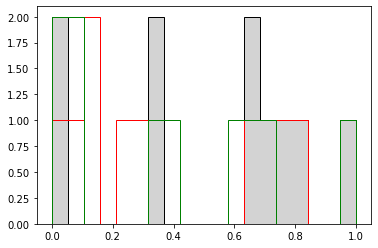

In [13]:
bins = np.linspace(0, 1, 20)
plt.hist(x_data_plot[:,2], histtype='stepfilled', edgecolor="black", facecolor="lightgray", bins = bins)
plt.hist(x_uniform[:,2], edgecolor="red", histtype="step", bins = bins)
plt.hist(x_variational[:,2], edgecolor="green", histtype="step", bins = bins)
plt.show()